**Краткий список того, что я сделал ради сходимости:**

1. Модифицировал CSPup блоки за счет добавления дополнительных функций активации и батч-нормализаций
2. Использовал довольно большой размер батча (768). Это очень сильно стабилизировало обучение, при размере батча 256 все было не так гладко.
3. Использовал label_smoothing чтобы поверхность ФП для дискриминатора была "помягче"
4. НЕ использовал полносвязные слои (где-то читал, что это помогает)
5. Подобрал параметры для оптимизаторов (D lr=0.0002, betas=(0.5, 0.999), G lr=0.001, betas=(0.5, 0.999)). Дискриминатору обучаемость ограничил за счет lr, обоим оптимизаторам уменьшил первую бету чтобы было меньше коллапсов (за счет уменьшения первого момента алгоритм оптимизации может выбраться из состояния коллапса).
6. Вместо ReLU на выходе генератора использовал tanh (это из предыдущего опыта взял), соответственно и данные отскейлил в [-1, 1]
7. Train loop я взял из своей работы по детекции аномалий на ганах из курса "Обработка и генерация изображений" (но и его потом немного поменял: добавил дополнительный forward pass для генератора после обновления весов дискриминатора)

**Что еще можно было сделать:**

1. Взять побольше картинок (у меня, к сожалению, оперативной памяти маловато сейчас)
2. Получше поиграться с параметрами оптимизатора и гипер-параметрами моделей
3. Попробовать другие train loop'ы
4. Взять батчи еще больше (небольшой запас все еще есть)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms as T

import numpy as np
import cv2
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


n_images_to_take = 50_000
batch_size = 768
noise_dim = 128
label_smoothing = 0.1
images_root = './dataset/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 100

In [2]:
class CSPup(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_ksize=2):
        super(CSPup, self).__init__()

        assert in_channels % 2 == 0

        self.half_channels = in_channels // 2

        self.left = nn.Sequential(nn.ConvTranspose2d(self.half_channels, out_channels, kernel_size=upscale_ksize, stride=2, padding=0),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU())
        # self.left = nn.ConvTranspose2d(self.half_channels, out_channels, kernel_size=upscale_ksize, stride=2, padding=0)
        self.right = nn.Sequential(nn.Sequential(nn.Conv2d(self.half_channels, self.half_channels, 
                                                           kernel_size=1, stride=1, padding=0),
                                                 nn.BatchNorm2d(self.half_channels),
                                                 nn.ReLU(),
                                                 nn.ConvTranspose2d(self.half_channels, self.half_channels, 
                                                                    kernel_size=upscale_ksize, stride=2, padding=0)),
                                   nn.Sequential(nn.Conv2d(self.half_channels, self.half_channels, 
                                                           kernel_size=3, stride=1, padding=1),
                                                 nn.BatchNorm2d(self.half_channels),
                                                 nn.ReLU(),
                                                 nn.Conv2d(self.half_channels, out_channels, 
                                                           kernel_size=3, stride=1, padding=1)))


    def forward(self, x):
        left_x = x[:, :self.half_channels]
        right_x = x[:, self.half_channels:]

        left_x = self.left(left_x)
        right_x = self.right(right_x)

        return left_x + right_x


class CSPupGenerator(nn.Module):
    def __init__(self):
        super(CSPupGenerator, self).__init__()

        self.cspup_blocks = nn.Sequential(CSPup(noise_dim, 1024, upscale_ksize=4), 
                                          CSPup(1024, 512), 
                                          CSPup(512, 256), 
                                          CSPup(256, 128),
                                          CSPup(128, 64))

        self.out = nn.Sequential(nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0),
                                 nn.Tanh())

    def forward(self, z):
        x = self.cspup_blocks(z)
        x = self.out(x)

        return x


generator = CSPupGenerator().to(device)

summary(generator, input_size=(batch_size, noise_dim, 1, 1), device=device, depth=5)

Layer (type:depth-idx)                             Output Shape              Param #
CSPupGenerator                                     [768, 3, 128, 128]        --
├─Sequential: 1-1                                  [768, 64, 64, 64]         --
│    └─CSPup: 2-1                                  [768, 1024, 4, 4]         --
│    │    └─Sequential: 3-1                        [768, 1024, 4, 4]         --
│    │    │    └─ConvTranspose2d: 4-1              [768, 1024, 4, 4]         1,049,600
│    │    │    └─BatchNorm2d: 4-2                  [768, 1024, 4, 4]         2,048
│    │    │    └─ReLU: 4-3                         [768, 1024, 4, 4]         --
│    │    └─Sequential: 3-2                        [768, 1024, 4, 4]         --
│    │    │    └─Sequential: 4-4                   [768, 64, 4, 4]           --
│    │    │    │    └─Conv2d: 5-1                  [768, 64, 1, 1]           4,160
│    │    │    │    └─BatchNorm2d: 5-2             [768, 64, 1, 1]           128
│    │    │    │    └

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # self.feature_extractor = nn.Sequential(ConvBlock(3, 16),
        #                                        ConvBlock(16, 32),
        #                                        ConvBlock(32, 64),
        #                                        ConvBlock(64, 128), 
        #                                        ConvBlock(128, 256),
        #                                        ConvBlock(256, 512))
        
        # self.out = nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False),
        #                          nn.Sigmoid())

        self.feature_extractor = nn.Sequential(ConvBlock(3, 8),
                                               ConvBlock(8, 16),
                                               ConvBlock(16, 32),
                                               ConvBlock(32, 64), 
                                               ConvBlock(64, 128),
                                               ConvBlock(128, 256))
        
        self.out = nn.Sequential(nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.Sigmoid())

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.out(x).squeeze(dim=(1, 2, 3))

        return x

discriminator = Discriminator().to(device)

summary(discriminator, input_size=(batch_size, 3, 128, 128), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [768]                     --
├─Sequential: 1-1                        [768, 256, 2, 2]          --
│    └─ConvBlock: 2-1                    [768, 8, 64, 64]          --
│    │    └─Conv2d: 3-1                  [768, 8, 64, 64]          384
│    │    └─BatchNorm2d: 3-2             [768, 8, 64, 64]          16
│    │    └─LeakyReLU: 3-3               [768, 8, 64, 64]          --
│    └─ConvBlock: 2-2                    [768, 16, 32, 32]         --
│    │    └─Conv2d: 3-4                  [768, 16, 32, 32]         2,048
│    │    └─BatchNorm2d: 3-5             [768, 16, 32, 32]         32
│    │    └─LeakyReLU: 3-6               [768, 16, 32, 32]         --
│    └─ConvBlock: 2-3                    [768, 32, 16, 16]         --
│    │    └─Conv2d: 3-7                  [768, 32, 16, 16]         8,192
│    │    └─BatchNorm2d: 3-8             [768, 32, 16, 16]         64
│    │  

  0%|          | 0/50000 [00:00<?, ?it/s]

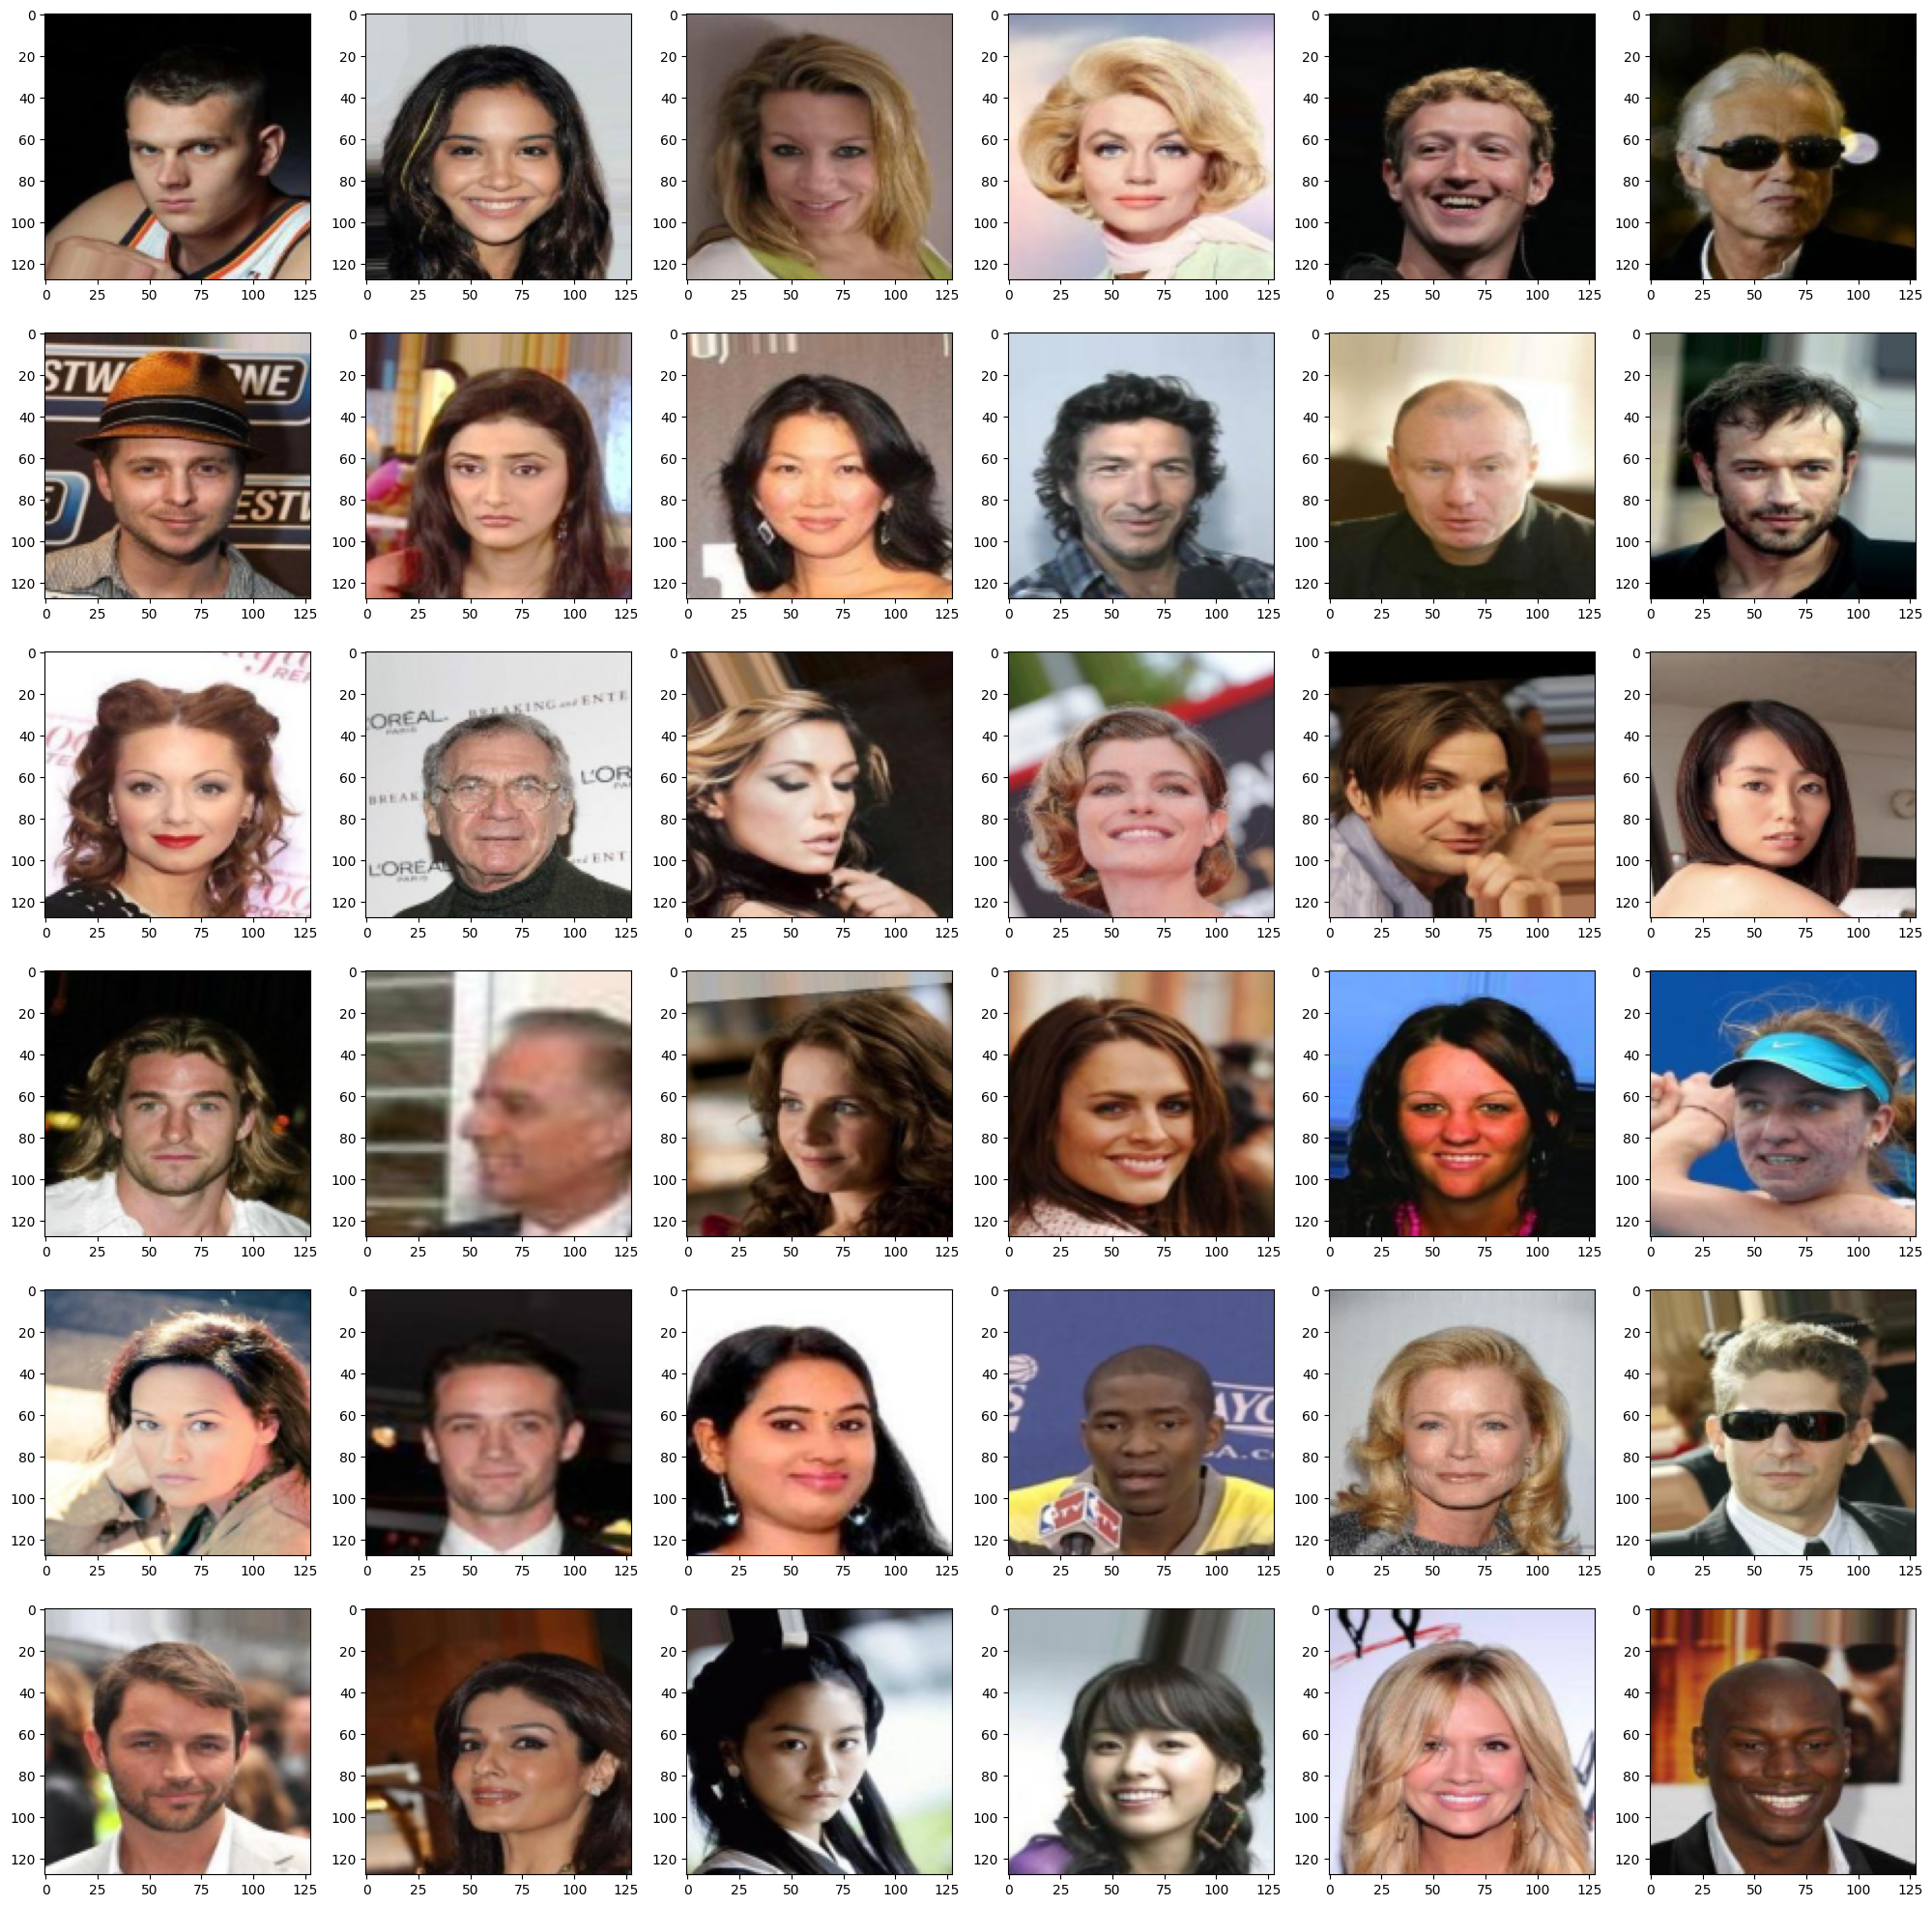

In [4]:
# Я так много памяти сэкономил
images = [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(images_root, fn)), cv2.COLOR_BGR2RGB), (128, 128), interpolation=cv2.INTER_AREA) for fn in tqdm(os.listdir(images_root)[:n_images_to_take])]

fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(25, 25))

for i in range(36):
    axes[i // 6, i % 6].imshow(images[i])

In [5]:
class ImagesDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx].permute(2, 0, 1)

images = torch.from_numpy(np.array(images)) / 127.5 - 1

# train_dataset = TensorDataset(images)
train_dataset = ImagesDataset(images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, drop_last=True)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [6]:
from tqdm.notebook import trange

sample_noise = torch.empty((36, noise_dim, 1, 1), dtype=torch.float32, device=device).normal_()

generator_loss_train = list()
discriminator_loss_train = list()

for epoch in trange(epochs):
    discriminator.train()
    generator.train()

    generator_loss = 0
    discriminator_loss = 0

    for real_imgs in train_loader:
        optimizerD.zero_grad()
        optimizerG.zero_grad()
        
        real_imgs = real_imgs.to(device, non_blocking=True)
        
        real_labels = torch.ones((batch_size,), device=device, dtype=torch.float) * (1 - label_smoothing)
        fake_labels = torch.zeros((batch_size,), device=device, dtype=torch.float)
        
        real_pred = discriminator(real_imgs)
        lossD_real = criterion(real_pred, real_labels)
        
        z = torch.empty((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device).normal_()
        fake_img = generator(z)

        fake_pred = discriminator(fake_img)
        lossD_fake = criterion(fake_pred, fake_labels)
        lossD = lossD_fake + lossD_real
        lossD.backward()    
        
        optimizerD.step()

        z = torch.empty((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device).normal_()
        fake_img = generator(z)

        fake_pred = discriminator(fake_img)
        lossG = criterion(fake_pred, real_labels)
        lossG.backward()

        optimizerG.step()

        generator_loss += lossG.item()
        discriminator_loss += lossD_fake.item() + lossD_real.item()

    with torch.no_grad():
        sample_fakes = generator(sample_noise).cpu().permute(0, 2, 3, 1) * 127.5 + 127.5

    sample_fakes_grid = torch.empty((6*128, 6*128, 3), dtype=torch.uint8)
    for i in range(6):
        for j in range(6):
            sample_fakes_grid[128*i: 128*(i+1), 128*j: 128*(j+1)] = sample_fakes[i*6+j]

    sample_fakes_grid = cv2.cvtColor(sample_fakes_grid.numpy().astype('uint8'), cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'./images_generated_epochwise/{epoch}.jpg', sample_fakes_grid)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch}/{epochs}, Generator loss: {round(generator_loss, 6)}, discriminator loss: {round(discriminator_loss, 6)}')

    generator_loss_train.append(generator_loss)
    discriminator_loss_train.append(discriminator_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100, Generator loss: 72.114871, discriminator loss: 81.349728
Epoch: 5/100, Generator loss: 204.536135, discriminator loss: 55.738933
Epoch: 10/100, Generator loss: 85.759637, discriminator loss: 78.513493
Epoch: 15/100, Generator loss: 73.094304, discriminator loss: 79.788862
Epoch: 20/100, Generator loss: 70.525523, discriminator loss: 79.817284
Epoch: 25/100, Generator loss: 71.491686, discriminator loss: 78.826173
Epoch: 30/100, Generator loss: 70.8095, discriminator loss: 77.434829
Epoch: 35/100, Generator loss: 74.612317, discriminator loss: 76.50746
Epoch: 40/100, Generator loss: 78.483396, discriminator loss: 74.335467
Epoch: 45/100, Generator loss: 78.928474, discriminator loss: 73.098942
Epoch: 50/100, Generator loss: 84.446961, discriminator loss: 71.522921
Epoch: 55/100, Generator loss: 86.294117, discriminator loss: 69.907544
Epoch: 60/100, Generator loss: 88.259479, discriminator loss: 68.731136
Epoch: 65/100, Generator loss: 88.715084, discriminator loss: 67.286

KeyboardInterrupt: 

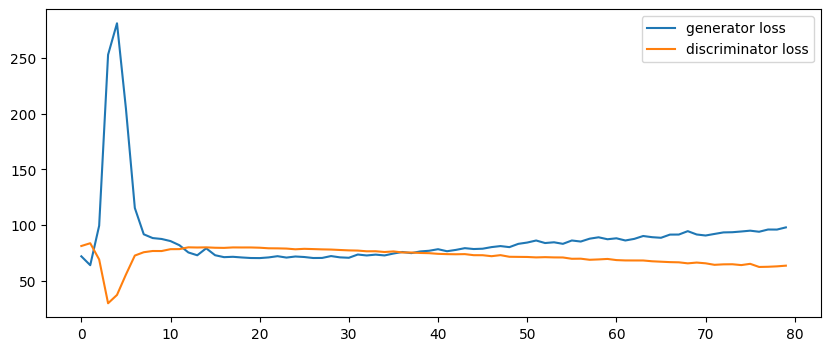

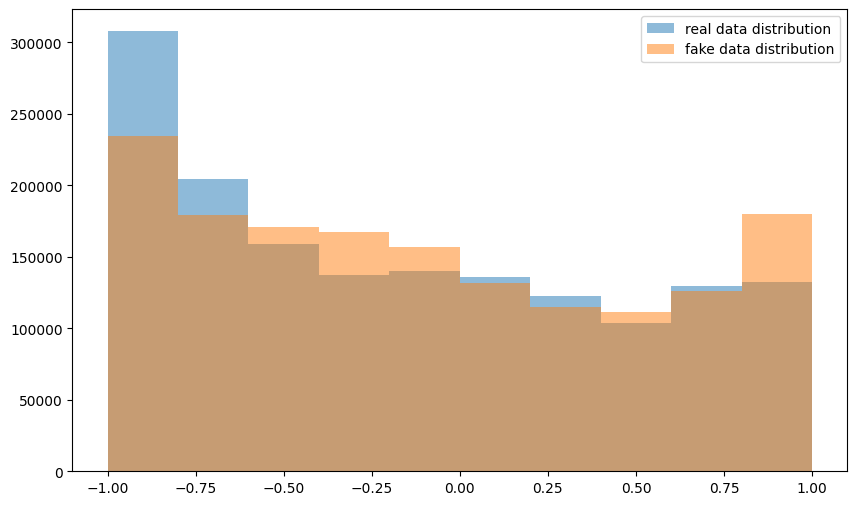

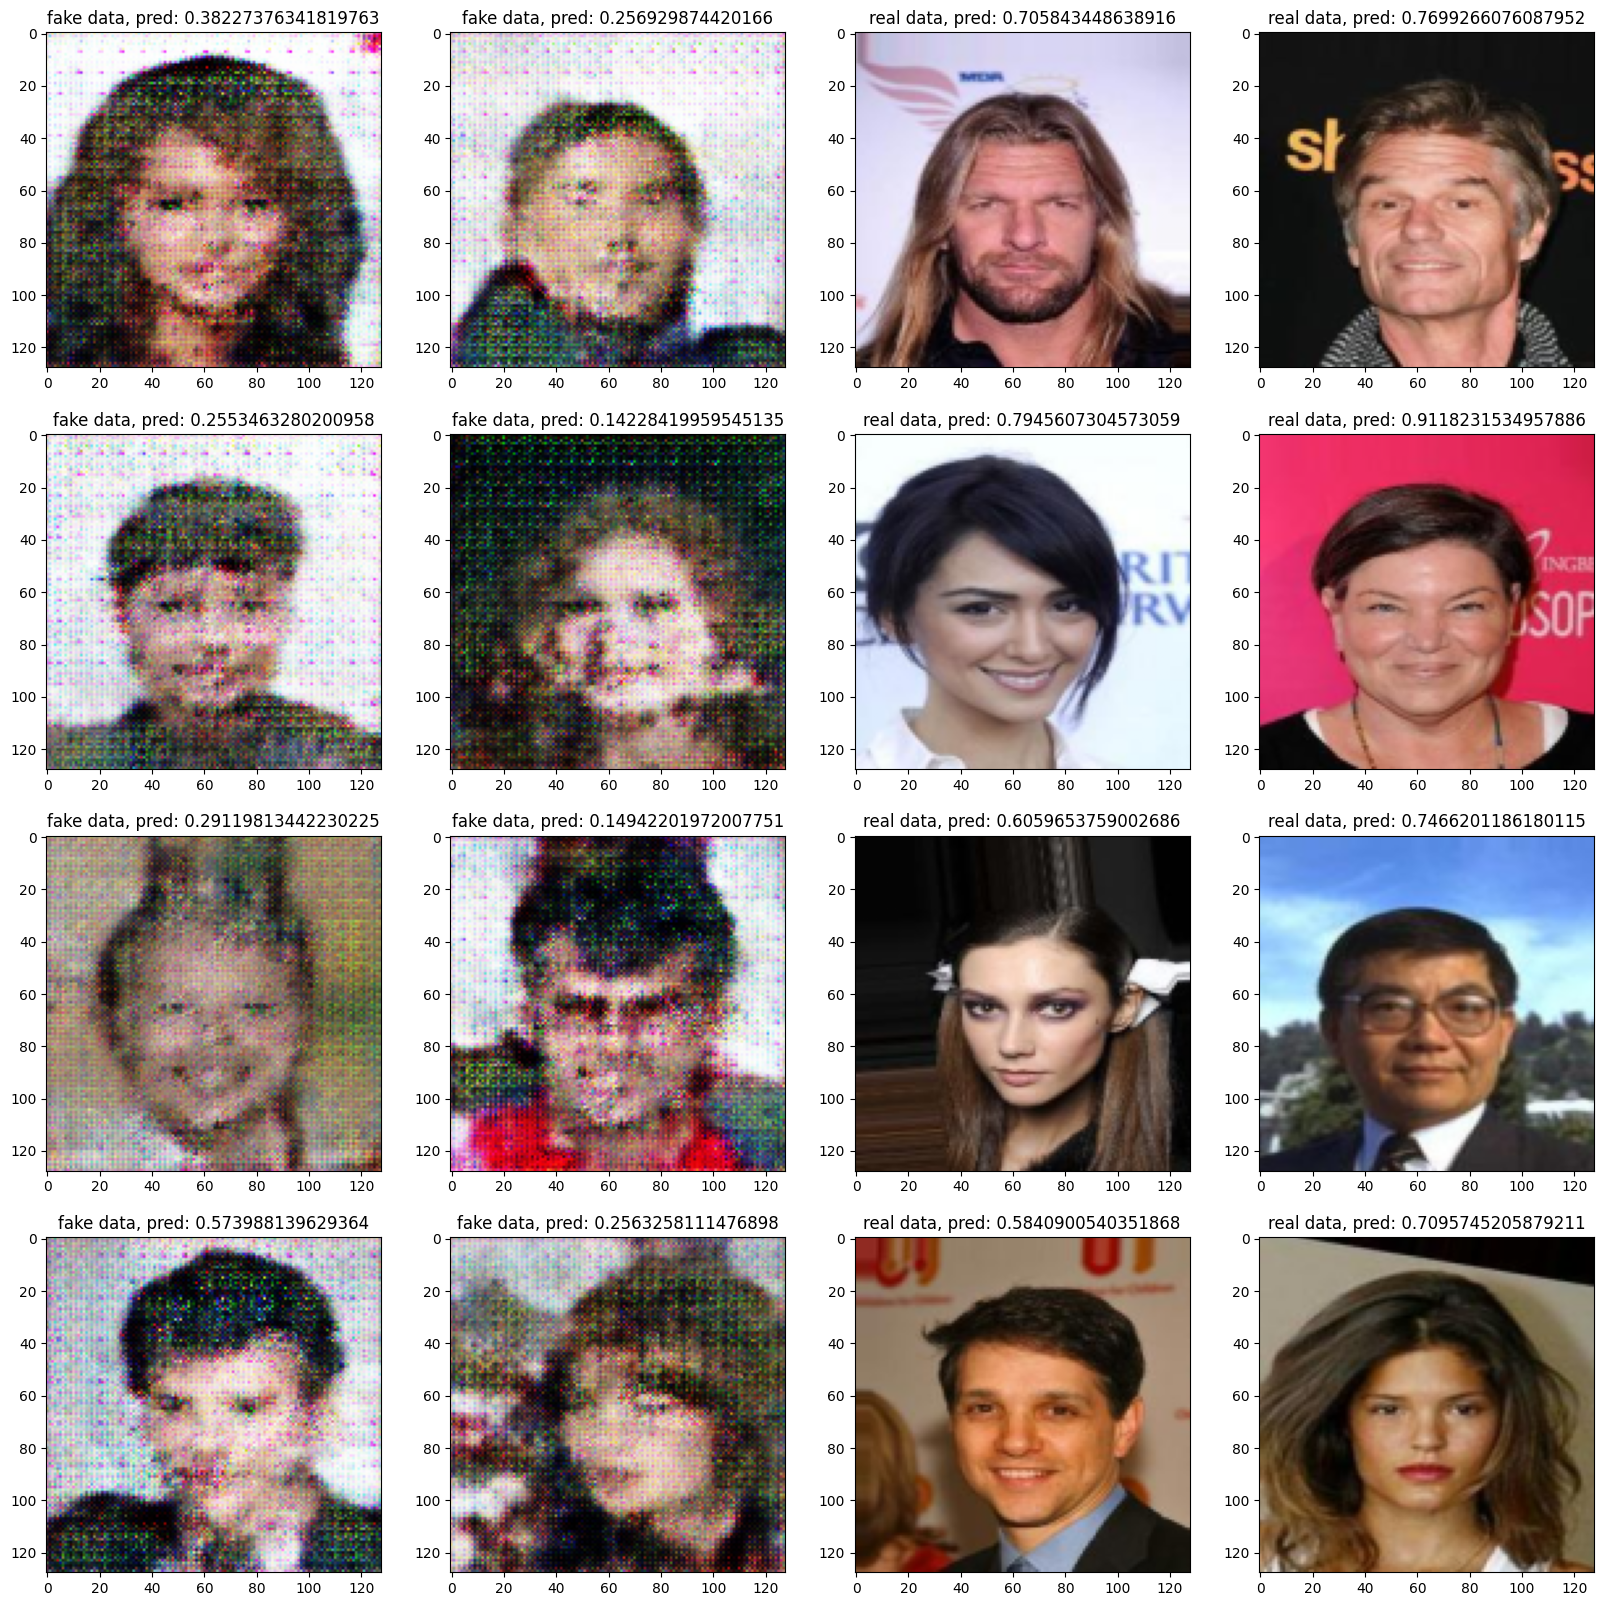

In [7]:
import matplotlib.pyplot as plt

z = torch.empty((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device).normal_()

with torch.no_grad():
    fake_imgs = generator(z)
    fake_imgs_preds = discriminator(fake_imgs).cpu().numpy()
    real_imgs_preds = discriminator(real_imgs).cpu().numpy()

fig = plt.figure(figsize=(10, 4))
plt.plot(generator_loss_train, label='generator loss')
plt.plot(discriminator_loss_train, label='discriminator loss')
plt.legend()

fig = plt.figure(figsize=(10, 6))
plt.hist(real_imgs[:32].view(-1).cpu(), label='real data distribution', alpha = 0.5)
plt.hist(fake_imgs[:32].view(-1).cpu(), label='fake data distribution', alpha = 0.5)
plt.legend()

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

fake_imgs = ((fake_imgs[:8].permute(0, 2, 3, 1).cpu().numpy() + 1) / 2)
real_imgs_ = ((real_imgs[:8].permute(0, 2, 3, 1).cpu().numpy() + 1) / 2)

for i in range(8):
    axes[i // 2, i % 2].imshow(fake_imgs[i], cmap='gray', vmin=-1, vmax=1)
    axes[i // 2, i % 2].set_title(f'fake data, pred: {fake_imgs_preds[i]}')

for i in range(8):
    axes[i // 2, 2 + i % 2].imshow(real_imgs_[i], cmap='gray', vmin=-1, vmax=1)
    axes[i // 2, 2 + i % 2].set_title(f'real data, pred: {real_imgs_preds[i]}')

In [8]:
import imageio
from pygifsicle import optimize


root = './images_generated_epochwise'
filenames = os.listdir(root)
filenames = sorted(filenames, key=lambda x: int(x.split('.')[0]))
images = []

for filename in filenames:
    img = cv2.imread(os.path.join(root, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384, 384), cv2.INTER_AREA)
    images.append(img)
imageio.mimsave('./exp/3.gif', images, fps=2)
optimize('./exp/3.gif')